## Introduction

## Data 

#### Data Collection

In [1]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
api_endpoints = {
    'frequently_bought_together': '/v1-beta/product-suggestions/frequently-bought-together',
    'relevant_products': '/v1-beta/product-suggestions/relevant-products',
    'similar_products': '/v1-beta/product-suggestions/similar-products',
    'food_waste': '/v1/food-waste/',
    'holidays': '/v1/holidays/',
    'stores': '/v2/stores/'
}

token = 'c344d66c-e418-4c2f-b122-3ee07a7f779e'  
base_url = 'https://api.sallinggroup.com'

# get data from a given API endpoint.
def get_api_data(endpoint, params=None):
    headers = {'Authorization': f'Bearer {token}'}
    try:
        response = requests.get(base_url + endpoint, headers=headers, params=params)
        response.raise_for_status()  
        return response.json()
    except requests.exceptions.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}') 
        return None
    except Exception as err:
        print(f'An error occurred: {err}')
        return None


#  clean and preprocess the data
def clean_food_waste_data(raw_data):
    if not raw_data:
        return None
    clearances = []
    for entry in raw_data:
        for clearance in entry.get('clearances', []):
            clearance_data = {**clearance['offer'], **clearance['product']}
            clearance_data.update(entry['store'])
            clearances.append(clearance_data)
    df = pd.DataFrame(clearances)
    return df

#  Normalize data formats
def normalize_data(df):
    df['endTime'] = pd.to_datetime(df['endTime'])
    df['lastUpdate'] = pd.to_datetime(df['lastUpdate'])
    df['startTime'] = pd.to_datetime(df['startTime'])
    df['currency'] = df['currency'].str.upper()  # ensure currency codes are in uppercase
    return df

# export the DataFrame to a CSV file.
def export_data(df, file_name):

    df.to_csv(f'{file_name}.csv', index=False)

# Collecting food waste data
food_waste_data = get_api_data(api_endpoints['food_waste'], params={'zip': '8000'})

if food_waste_data is not None:
    cleaned_data = clean_food_waste_data(food_waste_data)
    if cleaned_data is not None:
        normalized_data = normalize_data(cleaned_data)
        export_data(normalized_data, 'food_waste_data')
else:
    print("Data collection failed, no data to clean.")

# data cleaning
cleaned_data = clean_food_waste_data(food_waste_data)
# data normalizing
normalized_data = normalize_data(cleaned_data)

# Export
export_data(normalized_data, 'food_waste_data')

print("Data collection, cleaning, normalization, and export completed.")



Data collection, cleaning, normalization, and export completed.


#### Data Cleaning

In [2]:
df = pd.read_csv('food_waste_data.csv')

# Display the first few rows of the DataFrame
print(df.head())
# Get a summary of the data
print(df.describe())



  currency  discount            ean                    endTime   
0      DKK      6.95  5704000502476  2024-03-22 22:59:59+00:00  \
1      DKK     35.00  5712876783608  2024-03-22 22:59:59+00:00   
2      DKK      6.95  5712874224196  2024-03-22 22:59:59+00:00   
3      DKK     16.95  5712876482488  2024-03-22 22:59:59+00:00   
4      DKK     15.95  5707196277562  2024-03-22 22:59:59+00:00   

                  lastUpdate  newPrice  originalPrice  percentDiscount   
0  2024-03-21 10:05:37+00:00        10          16.95            41.00  \
1  2024-03-21 10:05:37+00:00        54          89.00            39.33   
2  2024-03-21 10:20:39+00:00        16          22.95            30.28   
3  2024-03-21 12:35:42+00:00        18          34.95            48.50   
4  2024-03-21 13:05:35+00:00        24          39.95            39.92   

                   startTime  stock  ...   
0  2024-03-19 06:14:29+00:00    7.0  ...  \
1  2024-03-21 05:35:07+00:00    1.0  ...   
2  2024-03-21 05:57:44+00:

In [3]:
# Check for missing values
print(df.isnull().sum())

currency            0
discount            0
ean                 0
endTime             0
lastUpdate          0
newPrice            0
originalPrice       0
percentDiscount     0
startTime           0
stock               0
stockUnit           0
categories          1
description         0
image              43
address             0
brand               0
coordinates         0
hours               0
name                0
id                  0
type                0
dtype: int64


In [4]:
# fill missing 'image' urls with a placeholder
df['image'] = df['image'].fillna('No image available')

# convert 'endTime', 'lastUpdate', and 'startTime' to datetime
df['endTime'] = pd.to_datetime(df['endTime'])
df['lastUpdate'] = pd.to_datetime(df['lastUpdate'])
df['startTime'] = pd.to_datetime(df['startTime'])

#### Data Analysis

##### 1. Discount patterns and stock levels.

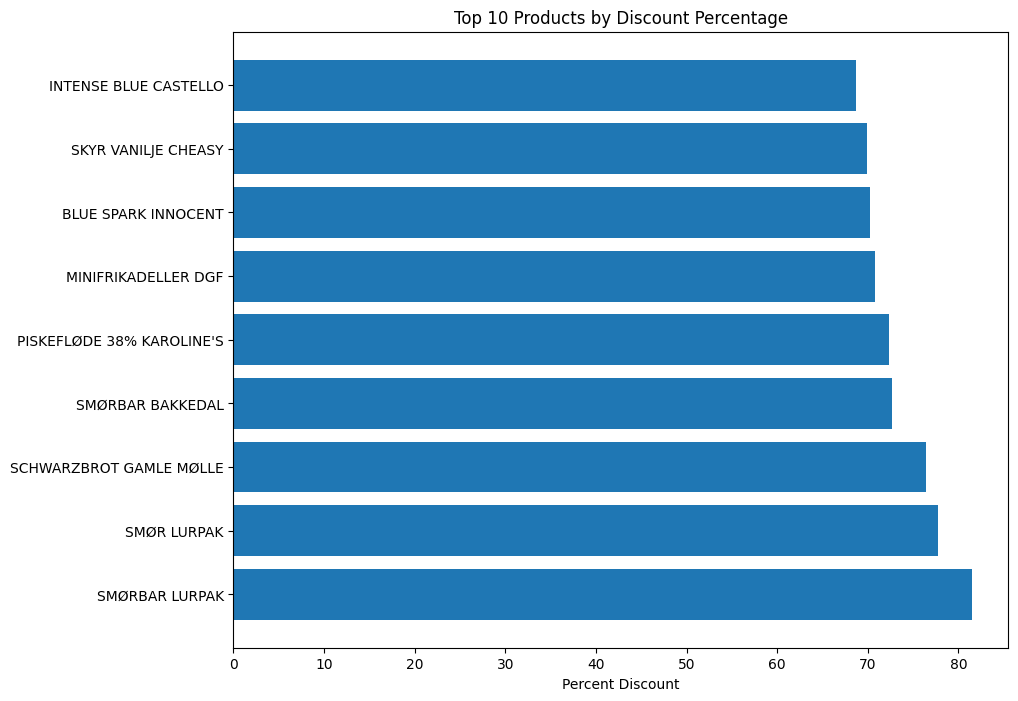

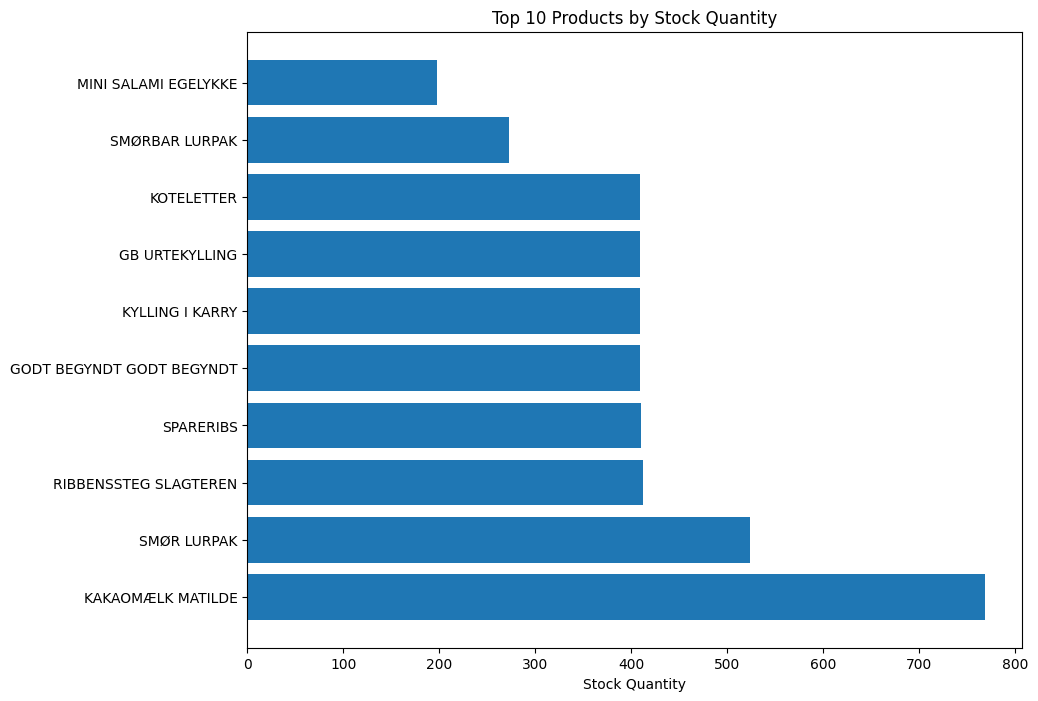

In [5]:
# which products have the highest discounts
top_discounts = df.sort_values(by='percentDiscount', ascending=False).head(10)

# which products have the most stock available
top_stock = df.sort_values(by='stock', ascending=False).head(10)

# polt the top discounts
plt.figure(figsize=(10, 8))
plt.barh(top_discounts['description'], top_discounts['percentDiscount'])
plt.xlabel('Percent Discount')
plt.title('Top 10 Products by Discount Percentage')
plt.show()

# plot the top stock levels
plt.figure(figsize=(10, 8))
plt.barh(top_stock['description'], top_stock['stock'])
plt.xlabel('Stock Quantity')
plt.title('Top 10 Products by Stock Quantity')
plt.show()


>The first plot shows the top 10 products with the highest discount percentages. These products might be prime candidates for promotion to reduce food waste since a higher discount may entice customers to purchase them before they expire.

>The second plot illustrates the top 10 products with the largest stock quantities. These could require urgent attention in terms of marketing and sales strategies to prevent potential waste.

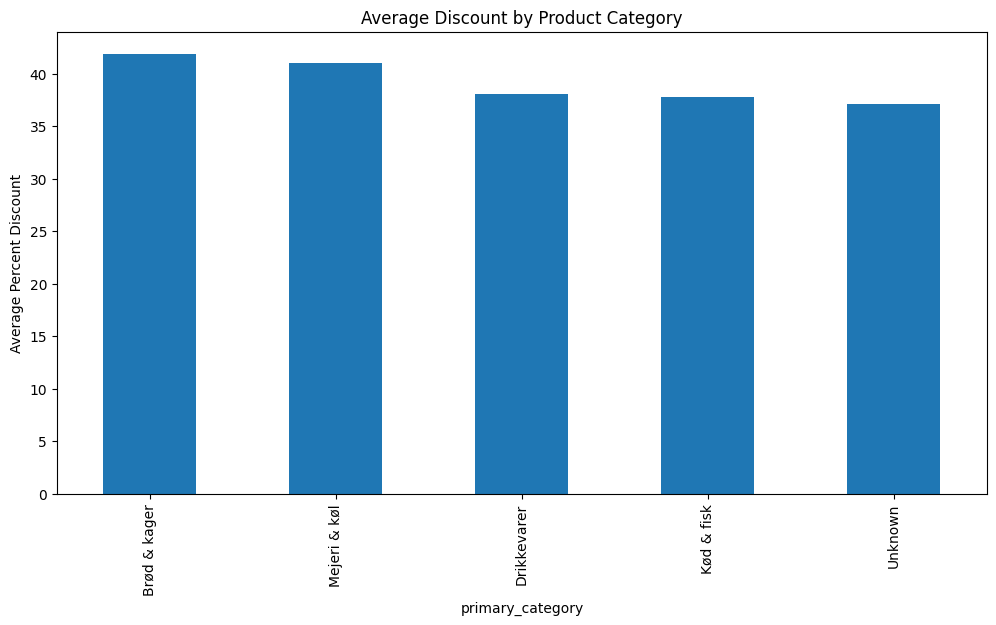

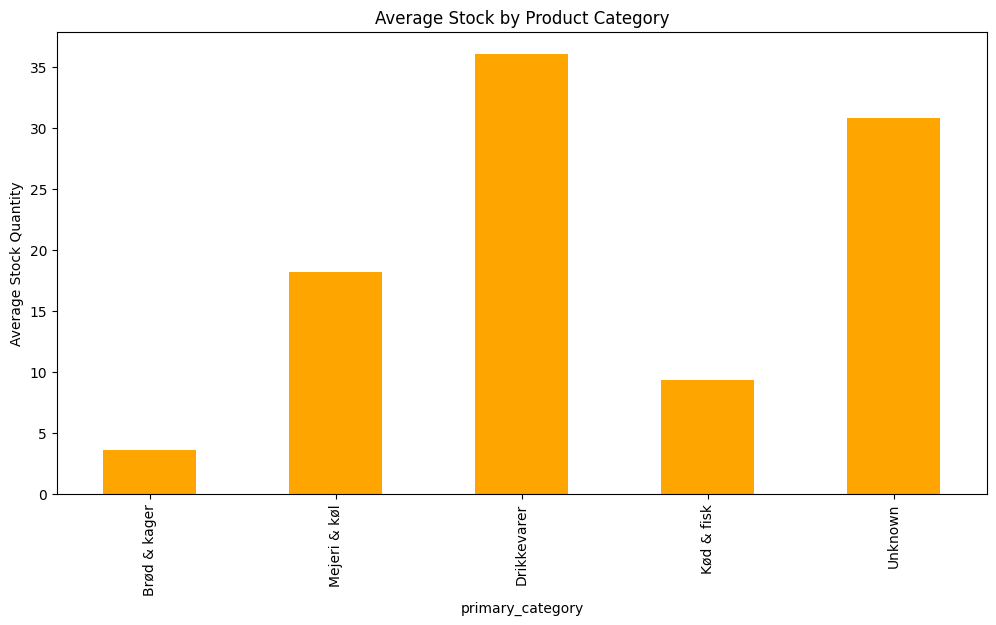

In [6]:
import json

# parse the JSON content
def safe_json_parse(maybe_json):
    try:
        return json.loads(maybe_json.replace("'", "\""))
    except (json.JSONDecodeError, AttributeError):
        return None

df['primary_category'] = df['categories'].apply(lambda x: list(safe_json_parse(x).values())[0].split('>')[0] if safe_json_parse(x) else 'Unknown')

# Group by primary category to see the average discount and stock
category_stats = df.groupby('primary_category').agg({'percentDiscount': 'mean', 'stock': 'mean'}).sort_values(by='percentDiscount', ascending=False)

# Plot the average discount
plt.figure(figsize=(12, 6))
category_stats['percentDiscount'].plot(kind='bar')
plt.ylabel('Average Percent Discount')
plt.title('Average Discount by Product Category')
plt.show()

# Plot the average stock
plt.figure(figsize=(12, 6))
category_stats['stock'].plot(kind='bar', color='orange')
plt.ylabel('Average Stock Quantity')
plt.title('Average Stock by Product Category')
plt.show()
